# データ生成

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (d.reshape(num, w * h), Y)

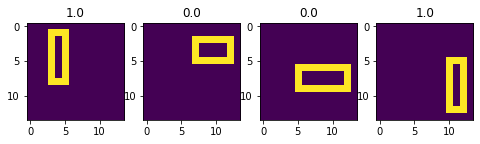

In [2]:
X, Y = data = make_rectangles_dataset(100, 14, 14)
Xt, Yt = test_data = make_rectangles_dataset(100, 14, 14)

plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(14,14))
    plt.title(Y[i, 0])


In [10]:
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt


class ConvVBGP:
  def __init__(self, num_inducing_points, h, w, patch_size, device="cuda" ):
    self.M = num_inducing_points
    self.device = device

    n_channels = 1
    self.patch_size = patch_size
    self.num_patches = (h - self.patch_size + 1) * (w - self.patch_size + 1) * n_channels

    self.inducing_patches = torch.rand( (self.M, self.num_patches, self.patch_size*self.patch_size), requires_grad=True, device=self.device )

    #self.theta0 = torch.rand(1, requires_grad=True )
    #self.theta1 = torch.rand(1, requires_grad=True )
    self.theta2 = torch.rand(1, requires_grad=True, device=self.device )

  def k(self, xi, xj, axis=2):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), axis)) 

  def get_patches(self, x):
    H = x.shape[2] 
    W = x.shape[3]
    n_channels = x.shape[1] 

    patches = x.unfold(2, self.patch_size, 1).unfold(3, self.patch_size, 1)
    patches = patches.reshape( (x.shape[0],n_channels*self.num_patches, self.patch_size*self.patch_size) )
    return patches

  def cov(self, xp1, xp2):
    # 一気に計算するとメモリが足りなくなる・・・
    """
    # 一次元増やしてパッチをコピー
    xp1 = xp1.view(xp1.shape[0], xp1.shape[1], 1, xp1.shape[2] )  #.repeat(1, 1, self.num_patches, 1)
    print(xp1.shape)

    # 一次元増やしてデータをコピー
    xp1 = xp1.view(xp1.shape[0], 1, xp1.shape[1], xp1.shape[2], xp1.shape[3]  ) #.repeat(1, len(xp2), 1, 1, 1)

    # 一次元増やしてパッチをコピー
    xp2 = xp2.view(xp2.shape[0], 1, xp2.shape[1], xp2.shape[2] ) #.repeat(1, self.num_patches, 1, 1 )

    # 一次元増やしてデータをコピー
    xp2 = xp2.view(1, xp2.shape[0], xp2.shape[1], xp2.shape[2], xp2.shape[3]  ) #.repeat(len(xp1), 1, 1, 1, 1)

    K = self.k( xp1, xp2, 4 ) 

    return torch.sum(K, [2,3])
    """

    N1 = xp1.shape[0]
    N2 = xp2.shape[0]
    K = torch.zeros(N1, N2, device=self.device)

    for n1 in range(N1):
      for n2 in range(N2):
        xpn1 = xp1[n1]
        xpn2 = xp2[n2]
        xpn1 = xpn1.view(xpn1.shape[0], 1, xpn1.shape[1] )
        xpn2 = xpn2.view(1, xpn2.shape[0], xpn2.shape[1] )
        K[n1, n2] = torch.sum(self.k( xpn1, xpn2 ))
    return K


  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt, dtype=torch.float32, device=self.device)
    self.yt = torch.tensor(yt, dtype=torch.float32, device=self.device)
    N = len(xt)


    optimizer = torch.optim.Adam( [self.inducing_patches], lr=0.1)
    #optimizer = torch.optim.Adam( [self.theta0, self.theta1, self.theta2], lr=0.1)

    # カーネルのパラメータが固定であれば，以下のテンソルの値は変わらない
    self.xt_patches = self.get_patches( self.xt )
    self.Knn = self.cov( self.xt_patches, self.xt_patches )

    for i in range(100):
      # カーネル行列を定義
      self.Kmm = self.cov( self.inducing_patches, self.inducing_patches )
      self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M, device=self.device)*0.001 )
      self.Knm = self.cov( self.xt_patches, self.inducing_patches )
      self.Kmn = torch.t( self.Knm )
      self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )
      self.sig2 = torch.exp(self.theta2)+0.01

      # loss関数を定義
      gauss = MultivariateNormal(torch.zeros(N, device=self.device), self.sig2*torch.eye(N, device=self.device)+self.Knn_)
      loss = -gauss.log_prob(self.yt) + torch.trace( self.Knn - self.Knn_ ) / (2*self.sig2)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("loss:", loss)

    # 論文中のΣ，A,B
    self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.Kmn, self.Knm) + torch.eye(self.M, self.M, device=self.device)*0.001 )
    A = torch.mm( torch.mm(self.Kmm, self.S ), self.Kmm )
    self.B = torch.mm(torch.mm(self.Kmm_inv, A), self.Kmm_inv )



  def predict( self, x ):
    K = len(x)
    x = torch.tensor(x, dtype=torch.float32, device=self.device)
    xp = self.get_patches(x)

    Kxm = self.cov( xp, self.inducing_patches )
    Kmx = torch.t( Kxm )

    sig = self.cov(xp, xp)
    sig += -torch.mm(torch.mm( Kxm, self.Kmm_inv), Kmx)
    sig += torch.mm( torch.mm( Kxm, self.B ), Kmx )

    mu = torch.mm(Kxm, self.Kmm_inv )
    mu = torch.mm(mu, 1/self.sig2 * torch.mm( torch.mm( torch.mm( self.Kmm, self.S ), self.Kmn), self.yt.reshape(-1,1) ) )
        
    return mu.detach().numpy().flatten(), sig.detach().numpy()

In [11]:
gp = ConvVBGP(10, 14, 14, 5, "cuda")
gp.learn(X.reshape(-1, 1, 14, 14), Y.flatten())

mu, sig = gp.predict(X.reshape(-1, 1, 14, 14))
acc = np.sum((mu>0.5)==Y.flatten())/Y.shape[0]
print("train acc:", acc)

mu, sig = gp.predict(Xt.reshape(-1, 1, 14, 14))
acc = np.sum((mu>0.5)==Yt.flatten())/Yt.shape[0]
print("test acc:", acc)

loss: tensor([87878.4219], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([82027.7578], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([60787.4570], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([38289.0039], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([19752.1582], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([12622.6025], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([14278.5918], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([14083.9707], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([10088.9053], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([8195.6162], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([7366.0693], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([6968.6343], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([6746.8120], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([6611.2070], device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor([6571.6670], device='cuda:0', grad_fn=<A

TypeError: ignored

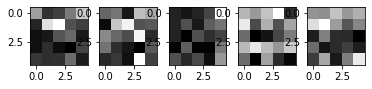

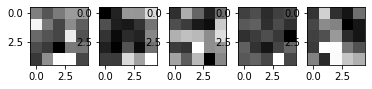

In [13]:
for i in range(5):
  plt.subplot(1,5,i+1)
  p = gp.inducing_patches[0, i, :].detach().cpu().numpy().reshape(5,5)
  plt.imshow(p, cmap="gray")
plt.show()

for i in range(5):
  plt.subplot(1,5,i+1)
  p = gp.inducing_patches[1, i, :].detach().cpu().numpy().reshape(5,5)
  plt.imshow(p, cmap="gray")